# Grad cam Visualization UKBB Reho

In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import torch.utils.data as torch_data
from nilearn import plotting
import nibabel as nib
import nilearn
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
import time
import pandas as pd
import torch.utils.data as torch_data

/data/zmohaghegh/venv/lib64/python3.6/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
#! pip install pytorch-gradcam

In [3]:
class GuidedBackprop():
    def __init__(self, model):
        self.model = model
    
    def guided_backprop(self, input, label):
        
        def hookfunc(module, gradInput, gradOutput):
            return tuple([(None if g is None else g.clamp(min=0)) for g in gradInput])
    
        input.requires_grad = True
        h = [0] * len(list(self.model.features) + list(self.model.classifier))
        for i, module in enumerate(list(self.model.features) + list(self.model.classifier)):
            if type(module) == nn.ReLU:
                h[i] = module.register_backward_hook(hookfunc)

        self.model.eval()
        output = self.model(input)
        self.model.zero_grad()
        output[0][label].backward()
        grad = input.grad.data
        grad /= grad.max()
        return np.clip(grad.cpu().numpy(),0,1)
        

In [4]:
class MriNetGrad(nn.Module):
    def __init__(self):
        super(MriNetGrad, self).__init__()
        
        self.downsample = nn.AvgPool3d(2, stride=2, padding=0)
        
        self.CNNlayer = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=3, stride=1),
            nn.ELU(),
            nn.Conv3d(64, 16, kernel_size=3, stride=1),
            nn.ELU(),
            nn.MaxPool3d(2)
        )  
        
        self.flat1 = nn.Linear(160000, 16)   
        self.flat2 = nn.Linear(16, 1)
        
        self.gradients = None
          
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x=self.downsample(x)
        x = self.CNNlayer(x)
        if x.requires_grad:
            h = x.register_hook(self.activations_hook)
        x=x.reshape(x.size(0), -1)        
        x=F.elu(self.flat1(x))                    
        x=self.flat2(x)
        
        return x
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.CNNlayer(x)

In [5]:
def train(epochs, net, criterion, optimizer, train_loader, valid_loader):

    best_acc = None
    best_model = None

    for epoch in range(0, epochs):
        print(f'*********Starting epoch {epoch+1}')
        
        print('start training :')
        
        train_loss = 0
        total =0 
        correct = 0
        
        net.train()

        for i, data in enumerate(train_loader, 0):

            inputs, labels = data

            optimizer.zero_grad()
            outputs = net(inputs)
            outputss = outputs.squeeze(1) #### [10,1] ---> [10]

            predicted = outputss.data > 0.0 # the loss function contain also a sigmoid layer <0 = false >0 =true

            labels = labels.double()

            loss = criterion(outputss, labels)

            loss.backward()

            optimizer.step() 

            train_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'acc_train :{100 * correct/total}')
        print (f'loss_train = {train_loss/total}')
        
        wandb.log({ "epoch": epoch ,"train_Loss": train_loss/total, "trian_acc" :100 * correct /total })

    
        print('Training has finished') 
        print('starting validation :')

        net.eval()

        valid_loss=0
        total=0
        correct=0

        with torch.no_grad():
            for i, data in enumerate(valid_loader, 0):
                #print(f'valid {i}')
                inputs, labels = data

                outputs = net(inputs)

                outputss=outputs.squeeze(1) #[10,1] ---> [10]
                labels=labels.double()

                # prediction 
                predicted = outputss.data > 0.0 # the loss function contain also a sigmoid layer <0 = false >0 =tru

                loss = criterion(outputss, labels)

                valid_loss += loss.item()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print(f'acc_valid :{100 * correct/total}')
            print (f'loss_valid = {valid_loss/total}')
            
            wandb.log({ "validation_acc" :100 * correct /total, "validation_Loss": valid_loss/total })
            
            current_valid_acc =100 * correct/total
            
            if not best_acc or best_acc < current_valid_acc:
                best_acc = current_valid_acc
                best_model= net
                
                print('Saving trained and validated model with best accuracy.')
                torch.save(net.state_dict(), 'best_model_gradcam_japanese')
            
        print('validation has finished.')
        
    return best_model      

In [6]:
def get_masks(validated_model, data_loader): # mask_type='grad_cam'
    
    masks = []
    validated_model.eval()
    
    for i, data in enumerate(data_loader, 0):

        image,labels =data

        logit = validated_model(image)
        logits= logit.mean()
        logits.backward()

        activation = validated_model.get_activations(image).detach()
        #print(activation.size())
        act_grad  = validated_model.get_activations_gradient() 
        #print(act_grad.size(),act_grad.type())

        pool_act_grad= torch.mean(input=act_grad,dim=[2,3,4], keepdim=True)
        activation = activation * pool_act_grad

        heatmap = torch.sum(activation, dim=1)       
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)
        heatmap = F.interpolate(heatmap.unsqueeze(0),(91,109,91), mode='trilinear', align_corners=False)

        masks.append(heatmap.numpy())
        
    masks_grad_cam = np.concatenate(masks,axis=0).squeeze(axis=1)
        
    return masks_grad_cam

### loading data summary measure

In [7]:
import pandas as pd
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset, TensorDataset
from torchvision import transforms
from sklearn.model_selection import KFold
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score,confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
import statistics
from sklearn.model_selection import train_test_split, StratifiedKFold

In [8]:
control_base_path = '/dbstore/zmohaghegh/UKBiobank_subset/Summary_measure_new/Control/ReHo/ReHo_Normalised_z/'
mdd_base_path = '/dbstore/zmohaghegh/UKBiobank_subset/Summary_measure_new/MDD/ReHo/ReHo_Normalised_z/'

#define data path for control and MDD seprately

control_files_path = [control_base_path + c for c in os.listdir(control_base_path) if c.startswith('R')]
mdd_files_path = [mdd_base_path + m for m in os.listdir(mdd_base_path) if m.startswith('R')]
print(len(control_files_path), len(mdd_files_path))

406 401


In [9]:
#loading data seprately and set a label column for Control=0 and MDD=1 nested list 

control_dataset_reho_zero = [[nib.load(c).get_fdata(),0] for c in control_files_path]
mdd_dataset_reho_zero = [[nib.load(m).get_fdata(),1] for m in mdd_files_path]

In [10]:
control_reho_zero_nan2= control_dataset_reho_zero
mdd_reho_zero_nan2 = mdd_dataset_reho_zero

print(len(mdd_reho_zero_nan2))
print(control_reho_zero_nan2[0][1]) ### subject label 
print(mdd_reho_zero_nan2[0][0].shape) ### subject nifti -summary measure


mdd_reho_zero_nan3 = np.array(mdd_reho_zero_nan2)
control_reho_zero_nan3 =np.array(control_reho_zero_nan2)


#####control
print(len(control_reho_zero_nan2))
print(control_reho_zero_nan2[0][0].shape)

control_reho_zero_nan3[0][1]

401
0
(91, 109, 91)
406
(91, 109, 91)


/data/zmohaghegh/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/data/zmohaghegh/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


0

In [11]:
#zero_nan_control
print(control_reho_zero_nan3.shape)
print(control_reho_zero_nan3[0][0].shape)
print(control_reho_zero_nan3[0][1])
print(control_reho_zero_nan3[100][1])
print(control_reho_zero_nan3[0].shape)
print(type(control_reho_zero_nan3))


for i in range(len(control_dataset_reho_zero)):    
    control_reho_zero_nan3[i][0] =np.nan_to_num(control_dataset_reho_zero[i][0],copy=True)
    control_reho_zero_nan3[i][1] =np.nan_to_num(control_dataset_reho_zero[i][1],copy=True)

(406, 2)
(91, 109, 91)
0
0
(2,)
<class 'numpy.ndarray'>


In [12]:
#zero_nan_mdd

print(mdd_reho_zero_nan3.shape)
print(mdd_reho_zero_nan3[0][0].shape)
print(type(mdd_reho_zero_nan3))

for i in range(len(mdd_dataset_reho_zero)):    
    mdd_reho_zero_nan3[i][0] =np.nan_to_num(mdd_dataset_reho_zero[i][0],copy=True)
    mdd_reho_zero_nan3[i][1] =np.nan_to_num(mdd_dataset_reho_zero[i][1],copy=True)

mdd_reho_zero_nan3.shape

(401, 2)
(91, 109, 91)
<class 'numpy.ndarray'>


(401, 2)

In [13]:
control_reho_4d_zero_nan = [[np.reshape(c[0], (1, 91, 109, 91)), c[1]] for c in control_reho_zero_nan3]
mdd_reho_4d_zero_nan = [[np.reshape(m[0], (1, 91, 109, 91)), m[1]] for m in mdd_reho_zero_nan3]

In [14]:
dataset_ukbb_reho_zero_nan= ConcatDataset([control_reho_4d_zero_nan, mdd_reho_4d_zero_nan])

print(dataset_ukbb_reho_zero_nan[0][0].shape)
print(dataset_ukbb_reho_zero_nan[400][1])
print(dataset_ukbb_reho_zero_nan[210][1])

dataset_ukbb_reho_zero_nan[400][0][0,:,54,45]

(1, 91, 109, 91)
0
0


array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.31026435,  1.34408677,  1.34430075,  1.28162777,
        1.18847239,  1.07319665,  0.93523437,  0.82378072,  0.66678351,
        0.44541788,  0.08238047, -0.19629201, -0.27754381, -0.33049449,
       -0.31276432, -0.33512637, -0.22530442, -0.09944099, -0.19001211,
       -0.4801808 , -0.75359291, -0.91668528, -0.8376472 , -0.89847213,
       -0.76954871, -0.35365254, -0.42679313, -0.76959944, -0.99272984,
       -0.89588839, -0.27528173,  0.11682796,  0.11155611, -0.05154822,
       -0.17248252, -0.69322795, -1.68781829, -1.82296419, -1.69314516,
       -1.78440464, -1.74946034, -1.58176041, -1.53866327, -2.20654583,
       -2.52570367, -2.06375575, -1.66327453, -1.52375674, -1.37778902,
       -1.16356814, -0.94626629, -0.67556   , -0.40097237, -0.15428519,
       -0.11252058, -0.23324284, -0.23374924, -0.00633637,  0.35

In [15]:
len(dataset_ukbb_reho_zero_nan)

807

In [16]:
len(dataset_ukbb_reho_zero_nan[0])

2

In [17]:
dataset_ukbb_reho_zero_nan[0][0].shape

(1, 91, 109, 91)

In [18]:
X= np.zeros((807,1,91, 109, 91))

In [19]:
for i in range(len(dataset_ukbb_reho_zero_nan)):
    X[i,:,:,:,:]= dataset_ukbb_reho_zero_nan[i][0]

In [20]:
dataset_ukbb_reho_zero_nan[1][0][0,:,54,45]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.76217383,  0.69174898,  0.63581926,  0.6073904 ,
        0.66648644,  0.76704597,  0.81617212,  0.76744598,  0.69569099,
        0.5513109 ,  0.37866759,  0.33465496,  0.43882072,  0.58456254,
        0.73302746,  0.83611375,  0.86925983,  0.82830834,  0.70931172,
        0.57172877,  0.3654896 ,  0.19388156,  0.06707721,  0.19200125,
        0.35886922,  0.38891232,  0.43781942,  0.11973609, -0.85917461,
       -1.77019382, -2.4736836 , -2.64725947, -2.47713351, -2.38749409,
       -2.39288902, -2.40874815, -2.40602469, -2.40947914, -2.47671771,
       -2.31595826, -1.80851853, -1.09307146, -0.29517499, -0.03300609,
       -0.07631877, -0.11759488, -0.05544051,  0.19912903,  0.31634346,
        0.42705613,  0.50524592,  0.60037661,  0.6239202 ,  0.64384604,
        0.68204331,  0.7527588 ,  0.76092184,  0.67594612,  0.70

In [21]:
X.shape

(807, 1, 91, 109, 91)

In [22]:
X[0][0,:,54,45]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.01864648e+00,
        8.37042928e-01,  6.76359534e-01,  5.98962367e-01,  4.38008547e-01,
       -3.03462557e-02, -6.60969913e-01, -8.09574664e-01, -5.86546838e-01,
       -3.76819074e-01, -2.05229502e-03,  3.36695015e-01,  5.03626764e-01,
        5.35209835e-01,  2.32292295e-01, -1.80770174e-01, -6.04689240e-01,
       -8.74008238e-01, -8.95970464e-01, -7.73294985e-01, -5.88675320e-01,
       -2.98190713e-01, -3.78859073e-01, -1.00868154e+00, -1.40709424e+00,
       -1.45681405e+00, -2.19172287e+00, -2.43466282e+00, -2.20212746e+00,
       -1.60374796e+00, -1.76433563e+00, -2.63044882e+00, -2.65422010e+00,
       -2.72807527e+00, -2.26484060e+00, -1.58695221e+00, -1.21248817e+00,
       -1.22374821e+00, -2.06073427e+00, -2.74004579e+00, -2.48910975e+00,
       -1.80755651e+00, -

In [23]:
import wandb
!wandb login 390734ff44d817dbba59927d4eb542e564627b3b

wandb: Appending key for api.wandb.ai to your netrc file: /data/zmohaghegh/.netrc


## Train model with grad hook

In [25]:
#splitting

dataset_size= len(dataset_ukbb_reho_zero_nan)
train_count = int(0.7 * dataset_size) 
valid_count= int(0.2 * dataset_size)
test_count = dataset_size - train_count -valid_count

print(dataset_size)
print(train_count)
print(valid_count)
print(test_count)

807
564
161
82


In [26]:
# load data splits

BATCH_SIZE = 1
EPOCHS=20
learning_rate= 0.00001

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset_ukbb_reho_zero_nan, (train_count, valid_count,test_count))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)  
valid_loader  = torch.utils.data.DataLoader(valid_dataset , batch_size=BATCH_SIZE, shuffle=True)

In [27]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [28]:
# training 

model = MriNetGrad()
model = model.double()

optimizer = optim.SGD(model.parameters(), momentum=0.9, lr = learning_rate, weight_decay=1e-3)
criterion = nn.BCEWithLogitsLoss() #loss_function 

wandb.init(project='Grad-Cam-japanese-reho')  
validated_network = train(EPOCHS, model, criterion, optimizer, train_loader, valid_loader)

wandb: Currently logged in as: zahramhn (use `wandb login --relogin` to force relogin)


*********Starting epoch 1
start training :
acc_train :52.304964539007095
loss_train = 0.695609208893679
Training has finished
starting validation :
acc_valid :52.17391304347826
loss_valid = 0.6911419738957836
Saving trained and validated model with best accuracy.
validation has finished.
*********Starting epoch 2
start training :
acc_train :52.4822695035461
loss_train = 0.6904750432029377
Training has finished
starting validation :
acc_valid :49.68944099378882
loss_valid = 0.6907374187185912
validation has finished.
*********Starting epoch 3
start training :
acc_train :57.6241134751773
loss_train = 0.6828105341975694
Training has finished
starting validation :
acc_valid :55.27950310559006
loss_valid = 0.6914678964488291
Saving trained and validated model with best accuracy.
validation has finished.
*********Starting epoch 4
start training :
acc_train :57.4468085106383
loss_train = 0.6777955169318465
Training has finished
starting validation :
acc_valid :57.142857142857146
loss_valid = 

# Masking

## Mask_type = gradcam  

In [29]:
masks_grad_cam = get_masks(validated_network,test_loader)
np.save('masks_grad_cam', masks_grad_cam)

In [30]:
X.shape

(807, 1, 91, 109, 91)

In [31]:
X[0].shape

(1, 91, 109, 91)

In [32]:
masks_grad_cam.shape

(82, 91, 109, 91)

In [33]:
import nibabel as nib

subject_mni_path='/dbstore/zmohaghegh/Japanese_subset/new_preprocessed/MDD/sub-0237/subject_preprocessed.nii.gz'

MNI_subject_nifti= nib.load(subject_mni_path)

MNI_subject= MNI_subject_nifti.get_fdata()
print(MNI_subject.shape)
np.count_nonzero(MNI_subject)
MNI_subject[22,:,22,22]

(91, 109, 91, 143)


array([ -2.26833916,  -1.8595928 ,  -1.42427039,  -1.14686942,
        -1.45473552,  -1.76952899,  -1.90885258,  -2.31048894,
        -2.85172582,  -3.35620451,  -3.98504066,  -7.26474142,
       -12.09087276, -16.89986229, -23.30436325, -28.93794632,
       -32.17663956, -33.31615067, -34.74957657, -37.29740143,
       -37.6268158 , -38.11040497, -39.02143097, -40.45081329,
       -42.21570969, -43.87636185, -45.87941742, -47.15038681,
       -47.85300446, -48.25161362, -48.04007339, -47.17084885,
       -45.85748672, -42.10831451, -38.32201385, -34.68455887,
       -31.27863503, -28.39966393, -27.35427666, -26.98165131,
       -27.36435509, -31.04919052, -34.80319977, -36.27709579,
       -37.44638824, -35.11296844, -32.83330536, -30.51328087,
       -28.53593063, -27.67544174, -27.00707817, -27.92362404,
       -29.08426285, -32.25624084, -36.31266785, -40.36865997,
       -45.28587723, -47.83198929, -49.04240799, -47.04821777,
       -46.38208389, -50.13655853, -56.10609055, -61.59

### visualization : plotting ROI

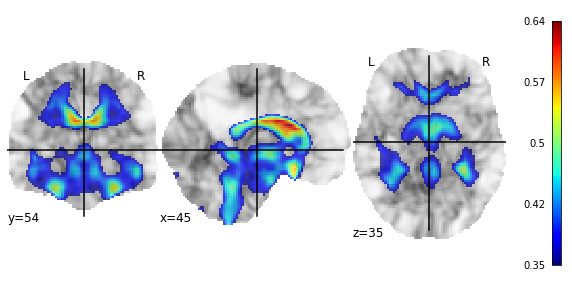

In [34]:
fig, axes = plt.subplots(figsize=(10,5))

ROI_img = nib.Nifti1Image(masks_grad_cam.mean(axis=0),affine=np.eye(4))

template_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))

plotting.plot_roi(ROI_img,template_img,cut_coords=(45,54,35), axes=axes,colorbar=True,cmap='jet',threshold=0.35)
plt.show()

fig.savefig("grad_cam.png", bbox_inches='tight')

## Mask_type= Guided Back-propagation

In [ ]:
# guided backpropagation

masks_guided_BP = get_masks(model, loader, device, mask_type='guided_backprop')

In [ ]:
if isTrain:
masks_gb = grad_cam.get_masks(model, loader, device, mask_type='guided_backprop')
    np.save(os.path.join(CHECKPOINTS_DIR,'masks_gb'), masks_gb)
else:
    masks_gb =  np.load(os.path.join(CHECKPOINTS_DIR, 'masks_gb.npy'))
    
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(masks_gb.mean(axis=0),affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.04)
plt.show()
fig.savefig("guided backpropagation.png", bbox_inches='tight')

## kfold training

In [ ]:
train_dataset_cv, test_dataset_cv = train_test_split(dataset_japan_reho_zero_nan, test_size=0.20, train_size=0.8,shuffle=True)
print(len(train_dataset_cv))
print(len(test_dataset_cv))

In [ ]:


wandb.init(project='Grad-Cam-japanese-reho')  

k_folds = 5
kfold_results = {}

# StratifiedKFold instead of KFOLD for balanced number of class for each fold
kfold = KFold(n_splits=k_folds, shuffle=True)  

#Hyper parameter
num_epochs = 20
batch_size = 1
learning_rate= 0.00001


#Define a Loss function 
criterion = nn.BCEWithLogitsLoss()

for fold, (train_ids, valid_ids) in enumerate(kfold.split(train_dataset_cv)):
    best_loss_cv= None
    
    print(f"FOLD {fold}\n--------------------------------")
    
    # Sample elements randomly from a given list of ids,
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_ids)
    
    # Define data loaders for training and testing data in this fold
    train_loader = torch.utils.data.DataLoader(train_dataset_cv, batch_size=batch_size, sampler=train_subsampler)
    valid_loader = torch.utils.data.DataLoader(train_dataset_cv, batch_size=batch_size, sampler=valid_subsampler)
    
    #define network
    network = MriNetGrad()
    network = network.double()
    
    # create our optimizer
    optimizer = optim.SGD(network.parameters(), momentum=0.9, lr = learning_rate, weight_decay=1e-3)
    
    # in the training loop:
    
    validated_network = train(num_epochs, network, criterion, optimizer, train_loader, valid_loader)
    

## debuging

In [ ]:
masks[1].shape

In [ ]:
print(len(masks))
masks_grad_cam = np.concatenate(masks,axis=0)
print(masks_grad_cam.shape)
masks_grad_cam=masks_grad_cam.squeeze(axis=1)
masks_grad_cam.shape

In [ ]:
mean_masks_grad_cam=masks_grad_cam.mean(axis=0)
mean_masks_grad_cam.shape

In [ ]:
masks_grad_cam = get_masks(validated_network,test_loader, mask_type='grad_cam')

In [ ]:
plot_roi

## Training model on whole data and saving 

In [ ]:
dataset = MriData(X, y)
loader = torch_data.DataLoader(dataset, batch_size=45, shuffle=True)  #45 - recommended value for batchsize

model = MriNetGrad()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)
_, _, _, _ = train(EPOCHS, model, criterion, optimizer, loader, loader, device, scheduler=scheduler, save=True, verbose=False,CHECKPOINTS_DIR=CHECKPOINTS_DIR, prefix='_all_grad') 

## Masking : mask_type= meaningfull perturbation

In [ ]:
if isTrain:
    loader = torch_data.DataLoader(dataset, batch_size=30, shuffle=False)
    net = mri_model.MriNet(C)
    net.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_model_all'), map_location=device))#change path
    net = net.float()
    net.eval()
    for param in net.parameters():
        param.requires_grad = False
    pred = np.concatenate(get_prediction(net, loader, device), axis=0)
    pertrub = MeanPertrub(device)
    masks_pertrub = pertrub.get_masks(X[:2], pred[:2], net)
    np.save(os.path.join(CHECKPOINTS_DIR,'masks_pertrub'), masks_pertrub)
else:
    masks_pertrub = np.load(os.path.join(CHECKPOINTS_DIR,'masks_pertrub.npy'))

In [ ]:
man_idx = np.arange(y.shape[0])[y == 1]
woman_idx = np.arange(y.shape[0])[y == 0]
man_masks = masks_pertrub[man_idx]
man_mean_mask = np.mean(man_masks, axis=0)
woman_masks = masks_pertrub[woman_idx]
woman_mean_mask = np.mean(woman_masks, axis=0)
mean_mask = man_mean_mask + woman_mean_mask

In [ ]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(np.clip(mean_mask, a_min=0, a_max=1), affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.55)
plt.show()
fig.savefig('meaningful perturbation.png', bbox_inches='tight')

## training

In [ ]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
EPOCHS = 20
m = 0
cross_mask =[]


for Mask in [man_mean_mask, woman_mean_mask, mean_mask]:
    torch.manual_seed(82)
    torch.cuda.manual_seed(82)
    np.random.seed(82)
    print('Doing {} mask'.format(m))
    m += 1
    cross_vall_acc_list = []
    j = 0
    for train_index, test_index in skf.split(X, y,):
        print('Doing {} split'.format(j))
        j += 1
    
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        train_dataset = mri_model.MriData(X_train, y_train)
        val_dataset = mri_model.MriData(X_test * Mask, y_test)
        train_loader = torch_data.DataLoader(train_dataset, batch_size=45, shuffle=True)  #45 - recommended value for batchsize
        val_loader = torch_data.DataLoader(val_dataset, batch_size=28, shuffle=False) 
        
        model = mri_model.MriNet(C)
        criterion = nn.NLLLoss( )
        optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)
    
        train(EPOCHS, model, criterion, optimizer, train_loader, val_loader,device,scheduler=scheduler, save=False, verbose=False) 
        cross_vall_acc_list.append(get_accuracy(model, val_loader, device))
    cross_mask.append(cross_vall_acc_list)
    
cv_acc = np.array(cross_mask)
np.save(os.path.join(CHECKPOINTS_DIR, 'cv_masks'), cv_acc)

In [ ]:
print('Mean cross-validation accuracy for man mask (10-folds):', np.mean(cv_acc[0]))
print('Std cross-validation accuracy for man mask (10-folds):', np.std(cv_acc[0], ddof=1))
print()
print('Mean cross-validation accuracy for woman mask (10-folds):', np.mean(cv_acc[1]))
print('Std cross-validation accuracy for woman mask (10-folds):', np.std(cv_acc[1], ddof=1))
print()
print('Mean cross-validation accuracy for conj mask (10-folds):', np.mean(cv_acc[2]))
print('Std cross-validation accuracy for conj mask (10-folds):', np.std(cv_acc[2], ddof=1))

## feature analysis

In [ ]:
X, y = np.load('/workspace/InterpretableNeuroDL/data/tensors.npy'), np.load('/workspace/InterpretableNeuroDL/data/labels.npy')#change path 
X = X[:, None,:,:,:]
print(X.shape, y.shape)
dataset = mri_model.MriData(X, y)
C = 32

In [ ]:
model = MriNet(c)
#summary(model, (1, 58, 70, 58))
mri_dataset = MriData(X, y)
mri_data_loader = torch.utils.data.DataLoader(mri_dataset, batch_size=47, shuffle=False) 

model.eval()
exists = False

for data, target in mri_data_loader:
    data = data.to(device)
    target = target.to(device)
    features = model.hidden1(data)
    
    #male features
    if exists:
        male_features = np.vstack([male_features, features[torch.where(target == 1)].detach().mean(axis=(2,3,4)).cpu().numpy()])
        male_entropy = np.vstack([male_entropy, count_entropy(features[torch.where(target == 1)].detach().cpu().numpy())])
    else:
        male_features = features[torch.where(target == 1)].detach().mean(axis=(2,3,4)).cpu().numpy()
        male_entropy = count_entropy(features[torch.where(target == 1)].detach().cpu().numpy())

    #female features
    if exists:
        female_features = np.vstack([female_features, features[torch.where(target == 0)].detach().mean(axis=(2,3,4)).cpu().numpy()])
        female_entropy = np.vstack([female_entropy, count_entropy(features[torch.where(target == 0)].detach().cpu().numpy())])
    else:
        female_features = features[torch.where(target == 0)].detach().mean(axis=(2,3,4)).cpu().numpy()
        female_entropy = count_entropy(features[torch.where(target == 0)].detach().cpu().numpy())
        exists = True
    
    del data, target, features

### Between-group differencies of 32 features mean voxel values

In [ ]:
m = male_features.mean(axis=0)
f = female_features.mean(axis=0)
m_ci = 2*male_features.std(axis=0)/np.sqrt(len(male_features))
f_ci = 2*female_features.std(axis=0)/np.sqrt(len(female_features))